In [107]:
import os, sys, copy, time, math, random, numbers, itertools, tqdm, importlib, re
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import rasterio
import torch
import yaml

from sklearn import metrics
from skimage import transform as trans
from pathlib import Path
from collections.abc import Sequence
from datetime import datetime, timedelta
from scipy.ndimage import rotate
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from torch import optim
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter

from IPython.core.debugger import set_trace

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
# The code cell is used to add the src directory to the Python path, making 
# it possible to import modules from that directory. 

module_path = os.path.abspath(os.path.join('../src'))
sys.path.insert(0, module_path)

In [109]:
from custom_dataset import CropData
from models.unet import Unet
from model_compiler import ModelCompiler
from custom_loss_functions import *
from utils import *

In [110]:
!pwd

/shishir/multi-temporal-crop-classification-baseline/notebooks


In [111]:
# The code cell loads a configuration file (default_config.yaml) using the YAML library and stores the 
# configuration data in the config dictionary. Then, it processes the global_stats section of the config 
# dictionary by expanding the lists for each stats based on the number of available time points. 
# As you can see we decided to generate a single set of normalization statistics and use it to 
# normalize all the time-points.

yaml_config_path = "/shishir/multi-temporal-crop-classification-baseline/config/default_config.yaml"  # replace this path to your own config file.
num_time_points = 3  # Change this number accordingly if you use a dataset with a different temporal length.

with open(yaml_config_path, 'r') as file:
    config = yaml.load(file, Loader=yaml.SafeLoader)

# Perform multiplication and concatenation for each key in global_stats
for key, value in config['global_stats'].items():
    config['global_stats'][key] = value * num_time_points

In [112]:
# config

In [113]:
# OPTIONAL
# pretty-print the config dictionary

import pprint
# pprint.pprint(config, width=100, compact=True)

### Steps for training and finetuning

In [114]:
# STEP 1-1: Data Preparation and Loading
# This code cell reads the input dataset for training, pre-processes it, and creates a 'torch.utils.Dataset' 
# object to be used in the model training process. It utilizes the 'CropData' class from the custom module 
# (CropData.py) to achieve this.

train_dataset = CropData(src_dir=config["src_dir"],
                         usage="train",
                         dataset_name="",
                         csv_path=config["train_csv_path"],
                         apply_normalization=config["apply_normalization"],
                         normal_strategy=config["normal_strategy"],
                         stat_procedure=config["stat_procedure"],
                         global_stats=config["global_stats"],
                         trans=config["transformations"], 
                         **config["aug_params"])

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 3083/3084 [01:03<00:00, 48.39it/s]

------ train dataset with 3083 patches created ------


In [115]:
# len(train_dataset.lbl_chips)
# config["transformations"]

In [116]:
# # train_dataset.img_fnames
# src_dir=config["src_dir"]
dataset_name=""
# # src_dir
# config["train_dataset_name"]

In [117]:
# img_fnames = [Path(dirpath) / f
#               for (dirpath, dirnames, filenames) in os.walk(Path(src_dir) ) 
#               for f in filenames 
#               if f.endswith(".tif") and ("merged" in f) and ('_'.join(Path(f).stem.split('_')[1:3]) in flag_ids)]

In [118]:
# img_fnames

In [119]:
# import os
# import random
# import csv
# import numbers
# import math
# import itertools
# import time
# import numpy as np
# import pandas as pd
# import rasterio
# import pickle
# import torch
# import matplotlib.pyplot as plt
# from torch.utils.data import DataLoader
# from normalization import do_normalization
# from pathlib import Path
# from IPython.core.debugger import set_trace


# class CropData(Dataset):
#     r"""
#     Create an iterable dataset of image chips
#     Arguments:
#         src_dir (str): Path to the folder contains data folders and files.
#         usage (str): can be either train, validate, or test.
#         dataset_name (str): Name of the training/validation dataset containing 
#                             structured folders for image, label, and mask.
#         csv_path (str): full path to the csv file containing the id of tiles used 
#                         for splitting the dataset into train and validation subsets.
#         apply_normalization (binary): decides if normalization should be applied.
#         normal_strategy (str): Strategy for normalization. Either 'min_max'
#                                or 'z_value'.
#         stat_procedure (str): Procedure to calculate the statistics used in normalization.
#                               Options:
#                                     - 'lab': local tile over all bands.
#                                     - 'gab': global over all bands.
#                                     - 'lpb': local tile per band.
#                                     - 'gpb': global per band.
#         global_stats (dict): Optional dictionary containing the 'min', 'max', 'mean', and 'std' arrays 
#                              for each band. If not provided, these values will be calculated from the data.
#         trans (list of str): Transformation or data augmentation methods; list 
#                              elements could be chosen from:
#                              ['v_flip','h_flip','d_flip','rotate','resize','shift_brightness']
#         **kwargs (dict, optional): Additional parameters for the specified transformation methods. 
#                         These can include:
#                              - scale_factor (tuple): Scaling factor for the 'resize' transformation 
#                                (default is (0.75, 1.5)).
#                              - rotation_degree (tuple): Degree range for 'rotate' transformation 
#                                (default is (-90, 90)).
#                              - bshift_subs (tuple): Band subsets for 'shift_brightness' transformation 
#                                (default is (6, 6, 6)).
#                              - bshift_gamma_range (tuple): Gamma range for 'shift_brightness' transformation 
#                                (default is (0.2, 2.0)).
#                              - patch_shift (bool): Whether to apply patch shift for 'shift_brightness' transformation 
#                                (default is True).
#     Returns:
#         A tuple of (image, label) for training and validation but only the image iterable 
#         if in the inference phase.
#     """

#     def __init__(self, src_dir, usage, dataset_name, csv_path, apply_normalization=False, 
#                  normal_strategy="z_value", stat_procedure="gpb", global_stats=None,
#                  trans=None, **kwargs):

#         self.usage = usage
#         self.dataset_name = dataset_name
#         self.apply_normalization = apply_normalization
#         self.normal_strategy = normal_strategy
#         self.stat_procedure = stat_procedure
#         self.trans = trans
#         self.kwargs = kwargs

#         assert self.usage in ["train", "validation", "inference"], "Usage is not recognized."

#         catalog = pd.read_csv(csv_path, header=None)
#         flag_ids = catalog[0].tolist()
#         #bad_tiles = ['305_343', '417_328', '419_322', '419_323', '417_321']
#         #flag_ids = [item for item in flag_ids_unrefined if item not in bad_tiles]

#         img_fnames = [Path(dirpath) / f
#                       for (dirpath, dirnames, filenames) in os.walk(Path(src_dir) / self.dataset_name) 
#                       for f in filenames 
#                       if f.endswith(".tif") and ("merged" in f) and ('_'.join(Path(f).stem.split('_')[1:3]) in flag_ids)]
#         img_fnames.sort()

#         lbl_fnames = [Path(dirpath) / f 
#                       for (dirpath, dirnames, filenames) in os.walk(Path(src_dir) / self.dataset_name) 
#                       for f in filenames 
#                       if f.endswith(".tif") and ("mask" in f) and ('_'.join(Path(f).stem.split('_')[1:3]).split(".")[0] in flag_ids)]
#         lbl_fnames.sort()

#         if self.usage in ["train", "validation"]:

#             self.img_chips = []
#             self.lbl_chips = []

#             for img_fname, lbl_fname in tqdm.tqdm(zip(img_fnames, lbl_fnames), 
#                                                   total=len(img_fnames)):
                    
#                 img_chip = load_data(Path(src_dir) / self.dataset_name / img_fname,
#                                      usage=self.usage,
#                                      is_label=False,
#                                      apply_normalization=self.apply_normalization,
#                                      normal_strategy=self.normal_strategy,
#                                      stat_procedure=self.stat_procedure,
#                                      global_stats=global_stats)
#                 img_chip = img_chip.transpose((1, 2, 0))

#                 lbl_chip = load_data(Path(src_dir) / self.dataset_name / lbl_fname, 
#                                      usage=self.usage,
#                                      is_label=True)

#                 self.img_chips.append(img_chip)
#                 self.lbl_chips.append(lbl_chip)
#         else:
#             self.img_chips = []
#             self.lbl_chips = []
#             self.ids = []
#             self.meta_ls = []

#             for img_fname, lbl_fname in tqdm.tqdm(zip(img_fnames, lbl_fnames),
#                                                   total=len(img_fnames)):
#                 img_chip, meta = load_data(Path(src_dir) / self.dataset_name / img_fname,
#                                            usage=self.usage,
#                                            is_label=False,
#                                            apply_normalization=self.apply_normalization,
#                                            normal_strategy=self.normal_strategy,
#                                            stat_procedure=self.stat_procedure,
#                                            global_stats=global_stats)
#                 img_chip = img_chip.transpose((1, 2, 0))
#                 lbl_chip = load_data(Path(src_dir) / self.dataset_name / lbl_fname, 
#                                      usage=self.usage, is_label=True)
                
#                 self.img_chips.append(img_chip)
#                 self.lbl_chips.append(lbl_chip)

#                 self.meta_ls.append(meta)

#                 img_id = '_'.join(img_fname.stem.split('_')[1:3])
#                 self.ids.append(img_id)

        
#         print(f"------ {self.usage} dataset with {len(self.img_chips)} patches created ------")


#     def __getitem__(self, index):
#         """
#         Support indexing such that dataset[index] can be used to get 
#         the (index)th sample.
#         """
#         kwargs = self.kwargs
        
#         if self.usage in ["train", "validation"]:
#             img_chip = self.img_chips[index]
#             lbl_chip = self.lbl_chips[index]

#             if self.trans and self.usage == "train":
#                 trans_flip_ls = [m for m in self.trans if "flip" in m]
#                 if random.randint(0, 1) and len(trans_flip_ls) >= 1:
#                     trans_flip = random.sample(trans_flip_ls, 1)
#                     img_chip, lbl_chip = flip(img_chip, lbl_chip, trans_flip[0])
            
#                 if random.randint(0, 1) and "rotate" in self.trans:
#                     deRotate = kwargs.get("rotation_degree", (-90, 90))
#                     img_chip, lbl_chip = center_rotate(img_chip, lbl_chip, deRotate)
                    
#                 if random.randint(0, 1) and "resize" in self.trans:
#                     scale_factor = kwargs.get("scale_factor", (0.75, 1.5))
#                     img_chip, lbl_chip = re_scale(img_chip, lbl_chip.astype(np.uint8),
#                                                   scale=scale_factor, crop_strategy="center")
                    
                
#             label = torch.from_numpy(np.ascontiguousarray(lbl_chip)).long()
#             # shape from (H,W,C) --> (C,H,W)
#             img_chip = torch.from_numpy(img_chip.transpose((2, 0, 1))).float()

#             return img_chip, label
        
#         else:
#             img_chip = self.img_chips[index]
#             lbl_chip = self.lbl_chips[index]
#             img_id = self.ids[index]
#             #img_meta = self.meta_ls[index]
#             img_meta = self.get_metadata_dict(self.meta_ls[index])
            
#             img_chip = torch.from_numpy(img_chip.transpose((2, 0, 1))).float()
#             label = torch.from_numpy(np.ascontiguousarray(lbl_chip)).long()

#             return img_chip, label, img_id, img_meta

#     def get_metadata_dict(self, meta):
#         img_meta = {}
#         for k, v in meta.items():
#             if isinstance(v, torch.Tensor):
#                 img_meta[k] = v.item()  # get Python number from tensor
#             elif isinstance(v, list):
#                 img_meta[k] = [x.item() if isinstance(x, torch.Tensor) else x for x in v]  # get Python number from tensor in list
#             else:
#                 img_meta[k] = v

#         # Handle crs and transform if present in the metadata
#         if "crs" in img_meta and not isinstance(img_meta["crs"], str):
#             img_meta["crs"] = img_meta["crs"].to_string()

#         if "transform" in img_meta and isinstance(img_meta["transform"], Affine):
#             img_meta["transform"] = [x for x in img_meta["transform"]]

#         return img_meta

#     def __len__(self):
#         return len(self.img_chips)

In [102]:
# !pwd
data_path="/shishir/All_Datasets/NASA-Crop-Classification/training_chips/chip_030_076_merged.tif"


In [103]:
# # list(train_dataset
# normal_strategy="z_value"
# stat_procedure="gpb"
# global_stats=None
dtype=np.float32

with rasterio.open(data_path, "r") as src:
    # meta = src.meta
    img = src.read()
    # if apply_normalization:
    # img = do_normalization(src.read(), normal_strategy, stat_procedure,
    #                         bounds=(0, 1), clip_val=1, global_stats=global_stats)
    img = img.astype(dtype)

#     # print(max(img.flatten()))
#     # else:
#     #     img = src.read()
#     #     img = img.astype(dtype)
img_data=img

In [104]:
# rgb_bands=(3, 2, 1)
# img_data = img[list(rgb_bands),:,:]



In [105]:
import random


Data shape before:(18, 224, 224)
Data shape After:(3, 6, 224, 224)
for T1_IMAGE:shape(6, 224, 224)
for T2_IMAGE:shape(6, 224, 224)
for T3_IMAGE:shape(6, 224, 224)


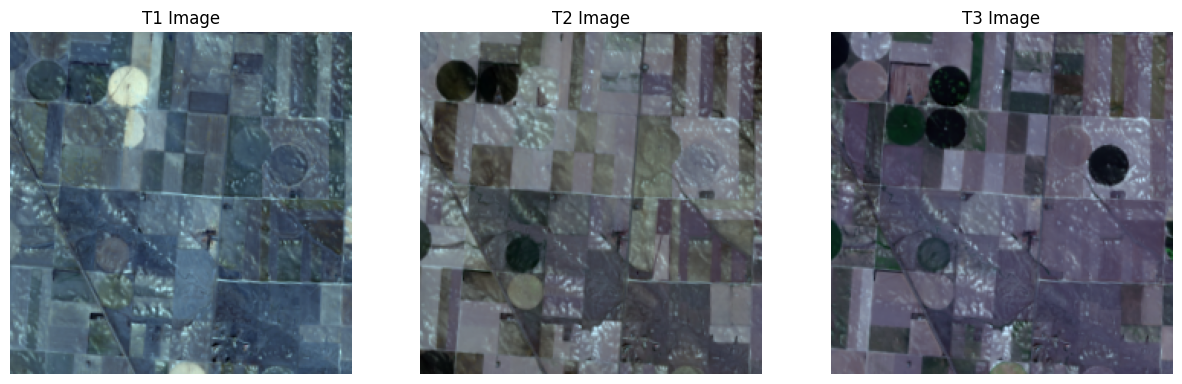

In [56]:
v1=random.randint(0, 3000)
img_data=static_dataset[v1][0].numpy()
print(f"Data shape before:{img_data.shape}")
img_data = img_data.reshape(3, 6, 224, 224)
print(f"Data shape After:{img_data.shape}")
 
# There are 3 images with each having 6 bands and lets indicate these images with t1, t2, t3
t1_img, t2_img, t3_img = img_data[0], img_data[1], img_data[2]
for img_ind, t_img in enumerate([t1_img, t2_img, t3_img]):
    print(f"for T{img_ind+1}_IMAGE:shape{t_img.shape}")

band_indices = {
    "Blue": 0,
    "Green": 1,
    "Red": 2,
    "Narrow NIR": 3,
    "SWIR 1": 4,
    "SWIR 2": 5
}
 
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
 
for img_ind, t_img in enumerate([t1_img, t2_img, t3_img]):
    # Choose bands for Red, Green, and Blue channels
    # Here, we select the Red, Green, and Blue bands respectively
    red_band = t_img[band_indices["Red"]]
    green_band = t_img[band_indices["Green"]]
    blue_band = t_img[band_indices["Blue"]]
    # Combine bands to create the RGB image
    rgb_image = np.dstack((red_band, green_band, blue_band))*1.0
    rgb_image = rgb_image.astype(np.float16)
    # Normalize each channel separately
    normalized_image = (rgb_image/rgb_image.max())*255
    normalized_image = np.uint8(normalized_image)
    # Visualize RGB image
    axes[img_ind].imshow(normalized_image)
    axes[img_ind].axis("off")
    axes[img_ind].set_title(f'T{img_ind+1} Image')

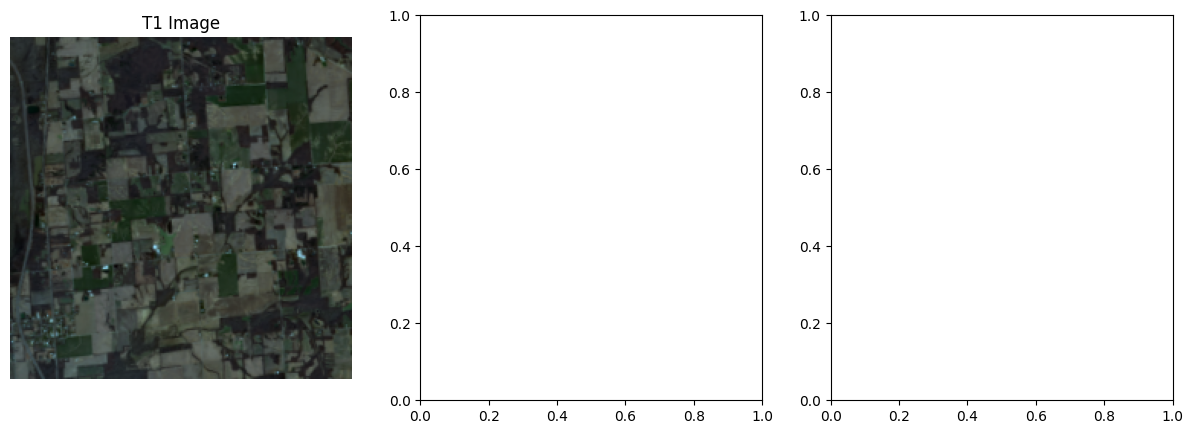

NameError: name 'label_data' is not defined

In [120]:
# OPTIONAL

l=show_random_patches(train_dataset, sample_num=3, rgb_bands=(3, 2, 1))

In [285]:
k

tensor([2, 1, 1,  ..., 2, 1, 1], dtype=torch.int32)

In [31]:
static_dataset=list(train_dataset)

In [38]:
static_dataset[15][0].shape

torch.Size([18, 224, 224])

In [205]:
max(k)

tensor(12.0944)

In [194]:
rgb_data = static_dataset[sample_index][0][list(rgb_bands),:,:].permute(1, 2, 0)

tensor(6, dtype=torch.int32)

(array([5.7370e+03, 0.0000e+00, 5.9725e+04, 0.0000e+00, 7.9113e+04,
        0.0000e+00, 5.8640e+03, 0.0000e+00, 7.5000e+01, 1.4000e+01]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

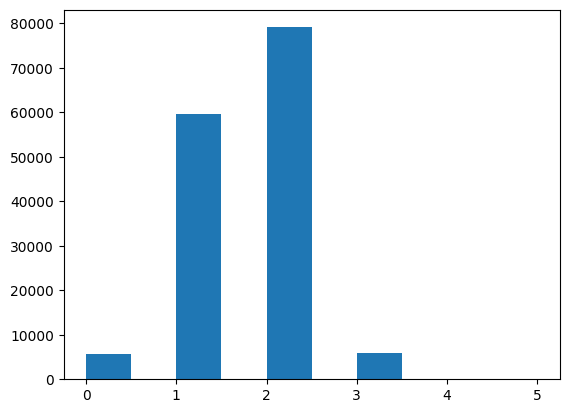

In [286]:
plt.hist(k)

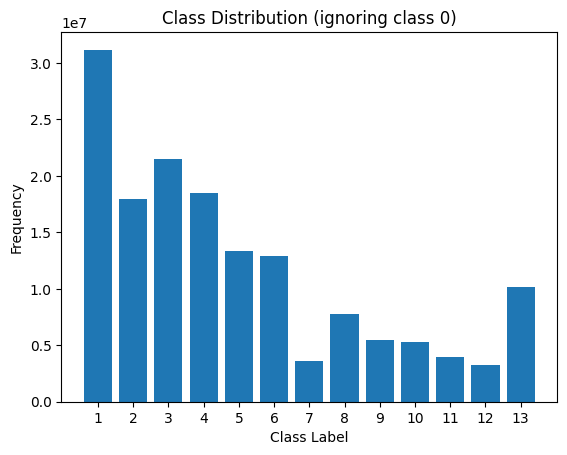

In [189]:
# OPTIONAL
# Check the distribution of categories in a dataset

labels_count = get_labels_distribution(train_dataset, num_classes=14, ignore_class=0)
plot_labels_distribution(labels_count)

In [ ]:
# STEP 1-2: Data Batching and Device Assignment
# This code cell batchifies the training dataset using the 'DataLoader' class from PyTorch. The 'DataLoader' 
# efficiently loads the 'train_dataset' in batches, facilitating memory management during training.

train_loader = DataLoader(train_dataset,
                          batch_size=config["train_BatchSize"], 
                          shuffle=True)

In [ ]:
# STEP 1-3
# Read the input dataset for validation, pre-process it and generate a 'torch.utils.Dataset' object 
# that can be accepted to get loaded into the model.

val_dataset = CropData(src_dir=config["src_dir"],
                       usage="validation",
                       dataset_name=config["train_dataset_name"],
                       csv_path=config["val_csv_path"],
                       apply_normalization=config["apply_normalization"],
                       normal_strategy=config["normal_strategy"],
                       stat_procedure=config["stat_procedure"],
                       global_stats=config["global_stats"],)

In [ ]:
# OPTIONAL
# Check the distribution of categories in a dataset

labels_count = get_labels_distribution(val_dataset)
plot_labels_distribution(labels_count)

In [ ]:
# STEP 1-4
# Batchify the validation dataset and put it on the defined 'Device'.

val_loader = DataLoader(val_dataset, 
                        batch_size=config["val_test_BatchSize"], 
                        shuffle=False)

In [ ]:
# STEP 2: Model Initialization
# The model is based on the U-Net architecture, a popular choice for image segmentation tasks. 

model = Unet(n_classes=config["n_classes"], 
             in_channels=config["input_channels"], 
             use_skipAtt=config["use_skipAtt"],
             filter_config=config["filter_config"],
             dropout_rate=config["train_dropout_rate"])

In [121]:
config["out_dir"]

'output6'

In [ ]:
# STEP 3: Model Compilation and Training Setup
# This code cell compiles the deep learning model, making it ready for training and evaluation. The 'ModelCompiler' 
# class is employed for this purpose, which offers a set of essential functionalities, such as model training 
# ('fit'), model saving, accuracy evaluation ('accuracy_evaluation'), inference ('inference'), and checkpointing 
# with resume capabilities. Additionally, it generates tensorboard reports and graphs for monitoring the training 
# process.

# Note: For training from scratch pass the "params_init" and "freeze_params" as None which results in loading a vanilla
# model with random initialization based on the "model_init_type" parameter. For training with warmup, only change the
# "params_init" to the path to model's saved parameter (not a checkpoint). For fine-tuning, change the "params_init" to 
# the path to model's saved parameter (by default its in the chckpt folder in working directory) and pass a list of integers
# representing the index of layers to be frozen.

compiled_model = ModelCompiler(model,
                               working_dir=config["working_dir"],
                               out_dir=config["out_dir"],
                               num_classes=config["n_classes"],
                               inch=config["input_channels"],
                               class_mapping=config["class_mapping"],
                               gpu_devices=config["gpuDevices"],
                               model_init_type=config["init_type"], 
                               params_init=config["params_init"],
                               freeze_params=config["freeze_params"])

In [ ]:
# STEP 4: Model Training and Validation
# This code cell trains and validates the compiled deep learning model for the specified number of epochs. 
# The model is trained using the "fit" method provided by the 'compiled_model' object. The training data 
# is obtained from 'train_loader', which contains batched samples and labels. Additionally, the 'val_loader' 
# is used for model validation during training. For each epoch the model reports the average loss value for both 
# training and validation phases, providing insights into its generalization capabilities.

# During the training the "fit" method will create a folder called 'chkpt' inside your working directory
# and save the checkpoints in user-defined intervals in that folder.
# Note: In case the training process is interrupted, you can change the "resume" argument and pass in the
# epoch to resume based on the created checkpoints.

criterion_name = config['criterion']['name']
weight = config['criterion']['weight']
ignore_index = config['criterion']['ignore_index']
gamma = config['criterion']['gamma']

if criterion_name == 'TverskyFocalLoss':
    criterion = TverskyFocalLoss(weight=weight, ignore_index=ignore_index, gamma=gamma)
else:
    criterion = nn.CrossEntropyLoss(weight=weight, ignore_index=ignore_index)
    

compiled_model.fit(train_loader,
                   val_loader, 
                   epochs=config["epochs"], 
                   optimizer_name=config["optimizer"], 
                   lr_init=config["LR"],
                   lr_policy=config["LR_policy"], 
                   criterion=criterion, 
                   momentum=config["momentum"],
                   checkpoint_interval=config["checkpoint_interval"],
                   resume=config["resume"],
                   resume_epoch=config["resume_epoch"],
                   **config["lr_prams"])

In [ ]:
# STEP 5
# Same model parameters
compiled_model.save(save_object="params")

In [ ]:
# STEP 6
# Generate the accuracy metrics.
metrics = compiled_model.accuracy_evaluation(val_loader, filename=config["val_metric_fname"])

### Steps for prediction

In [ ]:
test_dataset = CropData(src_dir=config["src_dir"],
                       usage="inference",
                       dataset_name=config["train_dataset_name"],
                       csv_path=config["test_csv_path"],
                       apply_normalization=config["apply_normalization"],
                       normal_strategy=config["normal_strategy"],
                       stat_procedure=config["stat_procedure"],
                       global_stats=config["global_stats"],)

In [ ]:
def meta_handling_collate_fn(batch):
    images = []
    labels = []
    img_ids = []
    img_metas = []

    # Unpack elements from each sample in the batch
    for sample in batch:
        images.append(sample[0])
        labels.append(sample[1])
        img_ids.append(sample[2])
        img_metas.append(sample[3])  # append the dict to the list

    # Stack images and labels into a single tensor
    images = torch.stack(images, dim=0)
    labels = torch.stack(labels, dim=0)
    
    return images, labels, img_ids, img_metas


test_loader = DataLoader(test_dataset, 
                        batch_size=config["val_test_BatchSize"], 
                        shuffle=False,
                        collate_fn=meta_handling_collate_fn)

In [ ]:
model = Unet(n_classes=config["n_classes"], 
             in_channels=config["input_channels"], 
             use_skipAtt=config["use_skipAtt"],
             filter_config=config["filter_config"],
             dropout_rate=config["train_dropout_rate"])

In [ ]:
compiled_model = ModelCompiler(model,
                               working_dir=config["working_dir"],
                               out_dir=config["out_dir"],
                               num_classes=config["n_classes"],
                               inch=config["input_channels"],
                               class_mapping=config["class_mapping"],
                               gpu_devices=config["gpuDevices"],
                               model_init_type=config["init_type"], 
                               params_init=config["params_init"],
                               freeze_params=config["freeze_params"])

In [ ]:
compiled_model.inference(test_loader, out_dir=config["out_dir"])